# Bayesian Outlier Modeling 
## For N-of-1 Outlier Analysis of TCGA against Normal Sets

Model outliers using a linear combination of approximations. Each background dataset, $X_i$, for each gene $j$, contributes a posterior distribution of expression $y_{i,j}$ to a linear model that learns the vector of $\beta$ weights corresponding to each background comparison distribution to model an $n$-of-1 tumor sample's distribution $z_j$. Samples drawn from the posterior distribution $z_j$ are then compared to the n-of-1 sample.

# Inputs

In [8]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm

import rnaseq_lib3 as r

In [9]:
df = pd.read_hdf('/mnt/data/Objects/tcga_gtex_tpm_norm_filt.hd5')
df.head(2)

,id,tissue,subtype,tumor,label,RP11-40C6.2,IGHG1,IGKC,KRT5,IGLC2,...,IGHEP1,RP11-44N21.4,GAPDHP61,P2RX5-TAX1BP3,RP11-408H20.3,RP13-726E6.2,CTB-43E15.1,ZNF878,OR2H2,RP4-530I15.9
GTEX-UTHO-1226-SM-3GAEE,GTEX-UTHO-1226-SM-3GAEE,Heart,Heart_Atrial_Appendage,no,gtex,0.000000,10.302941,10.712460,2.750618,7.780669,...,0.000000,0.0,0.0,0.150556,0.0,0.000000,0.0,0.070387,0.790754,0.815589
GTEX-146FH-1726-SM-5QGQ2,GTEX-146FH-1726-SM-5QGQ2,Esophagus,Esophagus_Mucosa,no,gtex,2.970847,8.778885,10.445933,12.393268,8.440056,...,0.176318,0.0,0.0,0.411426,0.0,0.176318,0.0,0.622930,0.042644,0.378503


In [10]:
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]
len(drug_genes)

85

Subset by dataset

In [11]:
cols = df.columns[:5].tolist()
drug_df = df[cols + drug_genes]

gtex = df[df.label == 'gtex']
normal = df[df.label == 'tcga-normal']
tumor = df[df.label == 'tcga-tumor']

In [12]:
def plot_gene_dist(n_of_1, gene):
    plt.axvline(n_of_1[gene], label='n-of-1', color='red')
    sns.kdeplot(gtex[gene], label='gtex')
    sns.kdeplot(normal[gene], label='normal')
    sns.kdeplot(tumor[gene], label='tumor')    
    plt.title(gene);

# Simple Model

PyMC3 doesn't allow `ObservedRVs` to be randomly sampled, so we can't directly learn RVs with observed data, and then randomly sample them as part of our linear model. Since this is a hierarchical model, we want to modify these priors during training anyway, so they can't technically be "observed" as that data is fixed. Which means we have to approximate fits for our gene expression distributions ahead of time, and use those fit parameters as starting parameters for our priors.

**Steps**
1. Get normal distribution fits for our gene set
    1. Using normal just to make things easy for now
2. Build Model using two background datasets: GTEx and TCGA-Normal
    1. We'll later break GTEx and TCGA-Normal up by tissue / disease
3. Train
    1. While my MCMC gently samples
4. Use $\alpha$ and $\beta$ parameters learned in the linear model to compute posterior distribution $z_j$ for each gene of interest
5. ???
6. Profit

## Learn Fits

Learn normal expression fits for all gene / dataset combinations.

In [56]:
genes = list(set(list(np.random.choice(df.columns[5:], 498, replace=False)) + ['ARAF', 'JAK2']))
len(genes)

500

In [57]:
fits = {}
for gene in genes:
    for name, dataset in [('gtex', gtex), ('normal', normal)]:
        key = f'{gene}-{name}'
        fits[key] = st.norm.fit(dataset[gene])

## Build Model

In [58]:
def train_linear(n_of_1, genes, datasets, fits, n_samples=200, tune=1000):
    """
    n_of_1: tumor sample 
    genes: genes to learn
    datasets: datasets to include
    fits = fits[gene-dataset] contain MAP of expression
    n_samples = Samples to learn
    """
    with pm.Model() as model:
        # Priors for linear model
        alpha = pm.Normal('alpha', 0, 5)
        beta = pm.Normal('beta', 0, 5, shape=len(datasets))
        
        # Convert fits into Normal RVs
        exp_rvs = {key: pm.Normal(key, *fits[key]) for key in fits}
        
        # Define linear model for each gene
        mu = {}
        for i, gene in enumerate(genes):
            mu[gene] = alpha
            for j, ds in enumerate(datasets):
                mu[gene] += exp_rvs[f'{gene}-{ds}'] * beta[j]
        
        # Single sigma across all genes
        sigma = pm.InverseGamma('sigma', 1)
        
        # Define z distributions for each mu
        z = {}
        for i, gene in enumerate(genes):
            obs = n_of_1[gene]
            z[gene] = pm.Laplace(gene, mu=mu[gene], b=sigma, observed=obs)
        
        # Calculate trace
        trace = pm.sample(n_samples, 
                          tune=tune, 
                          nuts_kwargs={'target_accept': 0.90},
                          njobs=12)
    return model, trace

## Train

Select an n_of_1 sample and train

In [50]:
tumor_id = 'TCGA-KK-A7B2-01'

In [51]:
n_of_1 = tumor.loc[tumor_id]

Check that it has an outlier for at least one gene relative to background datasets

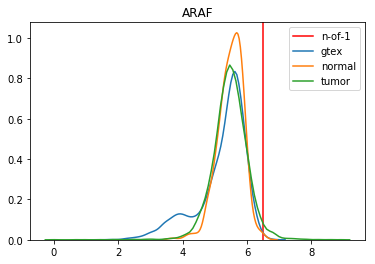

In [52]:
plot_gene_dist(n_of_1, gene='ARAF')

Find an example gene that is not an outlier

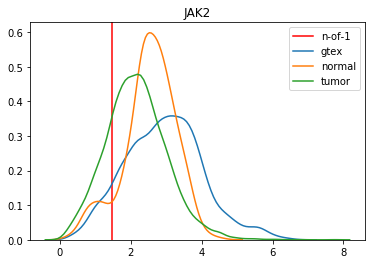

In [53]:
plot_gene_dist(n_of_1, gene='JAK2')

Run times
- 100 genes ~ 1h
    - 2 datasets. Converges
- 500 genes ~ 18.5 hours
    - 2 datasets. Converged, but slightly less well. 

In [59]:
datasets = ['gtex', 'normal']
model, trace = train_linear(n_of_1, genes, datasets, fits)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (12 chains in 12 jobs)
NUTS: [sigma, MORC2-normal, MORC2-gtex, DLG3-AS1-normal, DLG3-AS1-gtex, INO80C-normal, INO80C-gtex, FRS3-normal, FRS3-gtex, LINC01183-normal, LINC01183-gtex, NRIP1-normal, NRIP1-gtex, GBX1-normal, GBX1-gtex, JAK2-normal, JAK2-gtex, MEGF6-normal, MEGF6-gtex, CD164L2-normal, CD164L2-gtex, AP002518.1-normal, AP002518.1-gtex, COX6CP1-normal, COX6CP1-gtex, IRF2-normal, IRF2-gtex, COPS6-normal, COPS6-gtex, CST5-normal, CST5-gtex, TNFAIP8L2-normal, TNFAIP8L2-gtex, PIGC-normal, PIGC-gtex, TCF25-normal, TCF25-gtex, ZBTB24-normal, ZBTB24-gtex, TNFSF9-normal, TNFSF9-gtex, C11orf95-normal, C11orf95-gtex, PTPRZ1-normal, PTPRZ1-gtex, GGTLC1-normal, GGTLC1-gtex, SP8-normal, SP8-gtex, RP11-1102P16.1-normal, RP11-1102P16.1-gtex, TEX35-normal, TEX35-gtex, KCND2-normal, KCND2-gtex, GNPNAT1-normal, GNPNAT1-gtex, USMG5-normal, USMG5-gtex, RP4-706A16.3-normal, R

Sampling 12 chains: 100%|██████████| 14400/14400 [12:05:11<00:00, 31.78s/draws]  
The acceptance probability does not match the target. It is 0.7851207903308972, but should be close to 0.9. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


## TracePlot

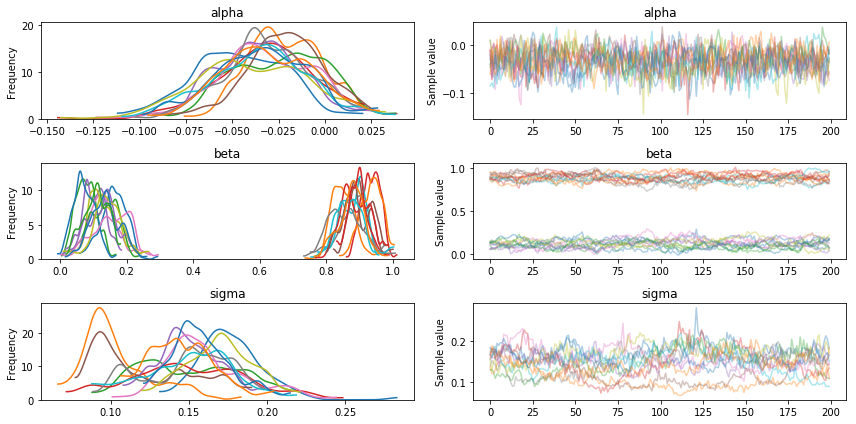

In [60]:
pm.traceplot(trace, varnames=['alpha', 'beta', 'sigma']);

## Parameter Estimates

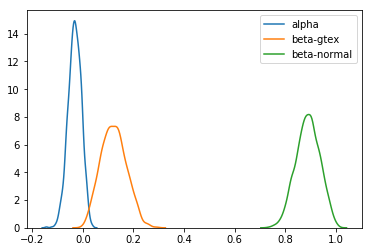

In [62]:
sns.kdeplot(trace['alpha'], label='alpha')
sns.kdeplot(trace['beta'][:,0], label='beta-gtex')
sns.kdeplot(trace['beta'][:,1], label='beta-normal');

## Posterior Sampling

In [63]:
def posterior_from_linear(trace, gene, n_of_1=n_of_1, gtex=gtex, normal=normal):
    # Get Median of priors
    a = trace['alpha']
    b1 = trace['beta'][:,0]
    b2 = trace['beta'][:,1]
    
    N = len(a)
    
    # 1000 samples from our datasets
    gtex_samples = np.random.choice(gtex[gene], N)
    normal_samples = np.random.choice(normal[gene], N)
    
    # Calculate z based on samples
    z = a + b1 * gtex_samples + b2 * normal_samples
    
    # Calculate PPP
    z_true = n_of_1[gene]
    ppp = sum(z_true < z) / len(z)

    # Plot
    plt.axvline(n_of_1[gene], color='red', label='z-true')
    plt.title(f'{gene} - P: {ppp}')
    sns.kdeplot(z, label='Linear-Equation');

In [64]:
def posterior_predictive_pval(ppc, gene, n_of_1=n_of_1):
    # Compute PPP
    z = ppc[gene]
    z_true = n_of_1[gene]
    ppp = sum(z_true < z) / len(z)
    
    # Plot
    plt.axvline(n_of_1[gene], color='red', label='z-true')
    plt.title(f'{gene} - P: {ppp}')
    sns.kdeplot(z, label='Posterior');

Sample from the posterior

In [65]:
ppc = pm.sample_ppc(trace, model=model)

100%|██████████| 200/200 [01:38<00:00,  2.57it/s]


For known non-outlier, check against linear model:

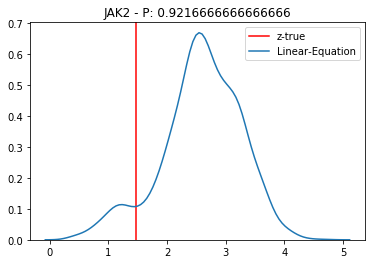

In [66]:
posterior_from_linear(trace, gene='JAK2')

And directly sampled from posterior:

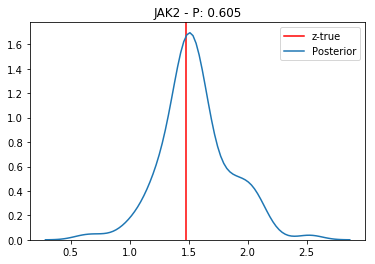

In [67]:
posterior_predictive_pval(ppc, gene='JAK2')

That is not what we're looking for

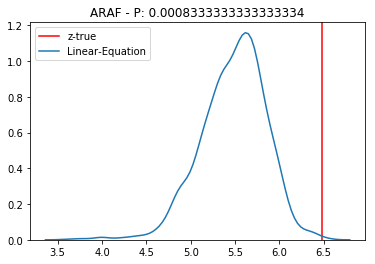

In [69]:
posterior_from_linear(trace, gene='ARAF')

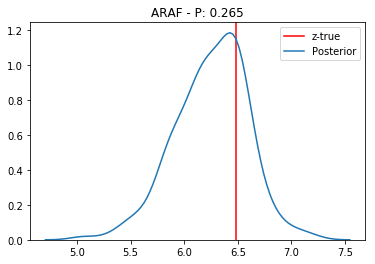

In [70]:
posterior_predictive_pval(ppc, gene='ARAF')

For known outlier

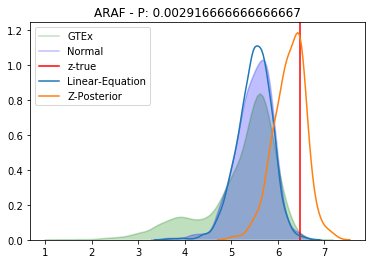

In [71]:
sns.kdeplot(gtex['ARAF'], c='green', shade=True, alpha=0.25, label='GTEx')
sns.kdeplot(normal['ARAF'], c='blue', shade=True, alpha=0.25, label='Normal')
posterior_check(trace, gene='ARAF')
sns.kdeplot(ppc['ARAF'], label='Z-Posterior');